In [17]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate , train_test_split , StratifiedShuffleSplit
from sklearn import   linear_model, metrics
from sklearn.linear_model import SGDClassifier as SGD

In [2]:
import seaborn as sns

In [3]:
train_directory = "data/train.csv"

train = pd.read_csv(train_directory, header=0 )

train['y'] = [1 if y == 'yes' else 0 for y in train['y']]

In [4]:
print(train.shape)
print(train.dropna().shape)
train.head(5)

(3222, 21)
(3222, 21)


age          job  marital          education default  housing     loan  \
0   30  blue-collar  married           basic.9y      no      yes       no   
1   39     services   single        high.school      no       no       no   
2   25     services  married        high.school      no      yes       no   
3   38     services  married           basic.9y      no  unknown  unknown   
4   47       admin.  married  university.degree      no      yes       no   

     contact month day_of_week  ...  campaign  pdays  previous     poutcome  \
0   cellular   may         fri  ...         2    999         0  nonexistent   
1  telephone   may         fri  ...         4    999         0  nonexistent   
2  telephone   jun         wed  ...         1    999         0  nonexistent   
3  telephone   jun         fri  ...         3    999         0  nonexistent   
4   cellular   nov         mon  ...         1    999         0  nonexistent   

  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  y  
0         -1.8          92.893          -46.2      1.313       5099.1  0  
1          1.1          93.994          -36.4      4.855       5191.0  0  
2          1.4          94.465          -41.8      4.962       5228.1  0  
3          1.4          94.465          -41.8      4.959       5228.1  0  
4         -0.1          93.200          -42.0      4.191       5195.8  0  

[5 rows x 21 columns]

Как можно видеть, пропущенных значений в датасете нет. Разделим признаки на числовые и категориальные

In [5]:
numeric_cols = train.describe().columns.tolist()
categorical_cols = list(set(train.columns.values.tolist()) - set(numeric_cols))

In [6]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
train_cat = enc.fit_transform(train[categorical_cols])
train_num = train[numeric_cols]

Проверим корреляцию числовых признаков с целевым

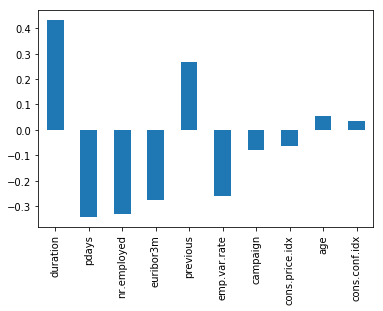

In [8]:
sorted_corr = sorted(train_num.iloc[:, :-1].corrwith(train_num.y).items(), key=lambda x: abs(x[1]), reverse=True)
zipped = list(zip(*sorted_corr))
pd.Series(zipped[1], index = zipped[0]).plot.bar()

Видно, что наибольшую корреляцию с целевым признаком дают признки duration, pdays, nr.employed, euribor3m, previous, emp.var.rate. Выберем их для обучения модели

In [36]:
features = list(zipped[0][:3])

In [37]:
X = train[features][:]
y = train['y'][:]

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

In [38]:
from sklearn.model_selection import GridSearchCV

def find_parameters(X, y):
    models = [
        ('SGD', SGD(max_iter=1000, tol=1e-3), {
            'loss': ['hinge', 'log'],
            'penalty': ['l1', 'l2'],
            'class_weight': [None, 'balanced']
        }),
        ('RandomForest', RandomForestClassifier(), {
            'n_estimators': [50, 100, 200],
            'max_depth': list(np.arange(5, 16)) + [None],
            'class_weight': [None, 'balanced']
        })
    ]

    results = []

    for model_name, model, param_grid in models:    
        model_cv = GridSearchCV(model, param_grid, cv=sss, scoring='roc_auc', iid=False)
        model_cv.fit(X, y)

        results.append((model_name, model_cv.best_score_, model_cv.best_params_))
    
    return results

def visualize_results(results):
    return pd.DataFrame(results, columns=['Method', 'Score',  'Best params']).set_index('Method')

In [39]:
results = find_parameters(X, y)
visualize_results(results)

Score                                        Best params
Method                                                                   
SGD           0.880531  {'class_weight': None, 'loss': 'hinge', 'penal...
RandomForest  0.934269  {'class_weight': None, 'max_depth': 6, 'n_esti...

In [30]:
results_with_cat = find_parameters(np.hstack((X, train_cat)), y)
visualize_results(results_with_cat)

Score                                        Best params
Method                                                                   
SGD           0.913937  {'class_weight': None, 'loss': 'hinge', 'penal...
RandomForest  0.923303  {'class_weight': None, 'max_depth': 10, 'n_est...

Качество моделей не изменилось от введения категориальных признаков, из чего можно заключить, что они не оказывают влияния на целевой показатель

In [35]:
print(results[1][2])
classifier = RandomForestClassifier(**results[1][2])
cv_result = cross_validate(classifier, X, y, cv=sss, scoring='roc_auc', return_train_score=False)
np.mean(cv_result['test_score'])

{'class_weight': None, 'max_depth': 7, 'n_estimators': 200}


0.9463835563312003

Дальнейшие возможности по улучшению модели:
1. Рассмотреть дополнительные классификаторы в дополнение к используемым двум
2. Более внимательно изучить структуру исходных данных, возможно, требуется дополнительная предобработка, например, стандартизация или нелинейное преобразование данных.
3. Попробовать применить ансамбли из нескольких классификаторов с помощью VotingClassifier
4. Перебрать используемые при обучении модели признаки